In [ ]:
!gdown --id 154Y9ekZqegNyIHe4kYZSNsSJOaGWfQ_H
!pip install folium
!pip install geopy

Downloading...
From: https://drive.google.com/uc?id=154Y9ekZqegNyIHe4kYZSNsSJOaGWfQ_H
To: /content/quake.csv
100% 45.0k/45.0k [00:00<00:00, 18.0MB/s]


In [83]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import itertools
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid")

## for geospatial
import folium
from folium.plugins import MarkerCluster
import geopy

## for machine learning
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import  silhouette_score, silhouette_samples
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OrdinalEncoder
from sklearn.decomposition import PCA

Dataset contains information about earthquakes: coordinates, depth and strength.   Your task is to cluster the data:  
Max: 10 points  
1. Exploratory analysis: 1  
2. Build K-Means with 15 clusters - 1  
3. Determine optimal number of clusters for K-Means - 1  
4. Create visualization for the obtained clusters - 1  
5. Try other clustering algorithms - 2  
6. Use labelled and unlabeled metrics to estimate quality of clusters you built. As ground truth use cluster labels from K-Means, choose most similar algorithm - 2  
7. Visualize the best clusterizations in your opinion on the world map. - 1


In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

In [ ]:
def folium_map(data, labels):
    data["richter"] = MinMaxScaler(feature_range=(1,13)).fit_transform(data[["richter"]])
    x, y = "latitude", "longitude"
    size = "richter"

    ## create color column
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 5, len(unique_labels))]
    lst_elements = sorted(list(labels.unique()))
    data["color"] = labels.apply(lambda x: lst_colors[lst_elements.index(x)])

    ## initialize the map with the starting location
    world_map = folium.Map(tiles="cartodbpositron", zoom_start=11)

    # clusters
    # marker_cluster = MarkerCluster().add_to(world_map)

    #  add points
    data.apply(lambda row: folium.CircleMarker(
            location=[row[x],row[y]],
            color=row["color"], fill=True,
            radius=row[size]).add_to(world_map), axis=1)

    ## add html legend
    legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
    for i in lst_elements:
        legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
        fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
        </i>&nbsp;"""+str(i)+"""<br>"""
    legend_html = legend_html+"""</div>"""
    world_map.get_root().html.add_child(folium.Element(legend_html))

    ## plot the map
    world_map

In [78]:
class Pipeline_class:
    def __init__(self, main_data):
        self.data = main_data
        self.cluster = pd.DataFrame(columns=["k_means15", "k_means_short", "k_means_full",
                                             "dbscan_short", "dbscan_full", "agglomerative"])

    def plot_elbow(self):
        short_dataset = self.data.drop(columns=["x", "y", "z"])
        list_ = [self.data, short_dataset]
        titles = ["Full data", "Short data"]
        for data, title in zip(list_, titles):
            inertias = []
            n_clust_grid = [i for i in range(1, 30)]
            for n_clusters in n_clust_grid:
                kmeans = KMeans(n_clusters=n_clusters, random_state=0)
                cluster_labels = kmeans.fit_predict(data)
                inertias.append(kmeans.inertia_)

            y = np.zeros(len(inertias) - 2)
            for i in range(len(inertias) - 2):
                y[i] = inertias[i] +  inertias[i + 2] - 2 *inertias[i + 1]

            fig, axes = plt.subplots(1, 2, figsize=(15,5))
            fig.suptitle(title, fontsize=16)
            axes[0].plot(n_clust_grid, inertias, marker="*")
            axes[0].set_title("Elbow method")
            axes[1].plot(n_clust_grid[1:-1], y, marker="*")
            axes[1].set_title("Second derivative")
            plt.tight_layout()
            plt.show()

    def neighbours_graph(self):
        short_dataset = self.data.drop(columns=["x", "y", "z"])
        list_ = [self.data, short_dataset]
        titles = ["Full data", "Short data"]

        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        i=0
        for data, title in zip(list_, titles):
            neighbours = NearestNeighbors(n_neighbors=2)
            nbrs = neighbours.fit(data)
            distances, indices = nbrs.kneighbors(data)

            distances = np.sort(distances, axis=0)
            distances = distances[:,1]

            axes[i].plot(distances)
            axes[i].set_title("Neighbours_graph for " + title)
            i+=1
        plt.tight_layout()
        plt.show()

    def agglomerative(self, depth):
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
        model = model.fit(self.data)
        plot_dendrogram(model, truncate_mode='level', p=depth)

        agglomerative = AgglomerativeClustering(n_clusters=depth)
        self.cluster["agglomerative"] = agglomerative.fit_predict(self.data)
        

    def kmeans15(self):
        kmeans = KMeans(n_clusters=15, random_state=0)
        kmeans_clusters = kmeans.fit_predict(self.data)
        self.cluster["k_means15"] = kmeans_clusters

    def make_clusterization(self, n_cluster_full, eps_full, min_samples_full,
                            n_cluster_short, eps_short, min_samples_short):
        
        kmeans_full = KMeans(n_clusters=n_cluster_full, random_state=0)
        dbscan_full = DBSCAN(eps=eps_full, min_samples=min_samples_full)
        kmeans_short = KMeans(n_clusters=n_cluster_short, random_state=0)
        dbscan_short = DBSCAN(eps=eps_short, min_samples=min_samples_short)

        kmeans_clusters_full = kmeans_full.fit_predict(self.data)
        dbscan_clusters_full = dbscan_full.fit_predict(self.data)
        kmeans_clusters_short = kmeans_short.fit_predict(self.data.drop(columns=["x", "y", "z"]))
        dbscan_clusters_short = dbscan_short.fit_predict(self.data.drop(columns=["x", "y", "z"]))
        
        self.cluster["k_means_full"] = kmeans_clusters_full
        self.cluster["dbscan_full"] = dbscan_clusters_full

        self.cluster["k_means_short"] = kmeans_clusters_short
        self.cluster["dbscan_short"] = dbscan_clusters_short

    def plot_silhoette(self, cluster_labels, n_clusters, title, full):

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(self.data) + (n_clusters + 1) * 10])

        if full:
            silhouette_avg = silhouette_score(self.data, cluster_labels)
            sample_silhouette_values = silhouette_samples(self.data, cluster_labels)
        else:
            silhouette_avg = silhouette_score(self.data.drop(columns=["x", "y", "z"]), cluster_labels)
            sample_silhouette_values = silhouette_samples(self.data.drop(columns=["x", "y", "z"]), cluster_labels)
        
        print("For n_clusters =", n_clusters, \
                "The average silhouette_score is :", silhouette_avg)
        
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        if full:
            data_2d = PCA(n_components=2).fit_transform(self.data.loc[:, ["depth", "richter", "x", "y", "z"]])
        else:
            data_2d = self.data.loc[:, ["depth", "richter"]].values
        colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data_2d[:, 0], data_2d[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for" + title + "clustering on sample data"
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

        plt.show()

    def dbscan_params(self, n_clusters):
        epsilon_param_options = np.arange(0.01, 2, 0.01)
        min_samples_param_options = np.arange(2, self.data.shape[1]+2, 1)
        param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

        print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

        params_dict = {}

        for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
            dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

            y_dbscan = dbscan.fit_predict(self.data)

            if len(set(y_dbscan) - set([-1])) == n_clusters:
                return param_set[0], param_set[1]


    def metrices(self, n_clusters):

        metrices_data = pd.DataFrame(columns=["GT", "AG", "DBSCAN"])

        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        eps, min_samples = self.dbscan_params(n_clusters=n_clusters)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        

        metrices_data["AG"] = agglomerative.fit_predict(self.data)
        metrices_data["GT"] = kmeans.fit_predict(self.data)
        metrices_data["DBSCAN"] = dbscan.fit_predict(self.data)

        label_cols = ['AG', 'DBSCAN']
        for col in label_cols:
            print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(metrices_data["GT"], metrices_data[col])}')
            print(f'Adjusted rand score for {col} = {adjusted_rand_score(metrices_data["GT"], metrices_data[col])}')

In [66]:
data = pd.read_csv("/content/quake.csv")
data.columns=["depth", "latitude", "longitude", "richter"]

# EDA

First of all, let's look at the depth of the earthquakes. The histogram shows that the distribution is very skewed. We can transform it using simple log transforamtion. But I don't think this is a really good idea in the case of clustering.

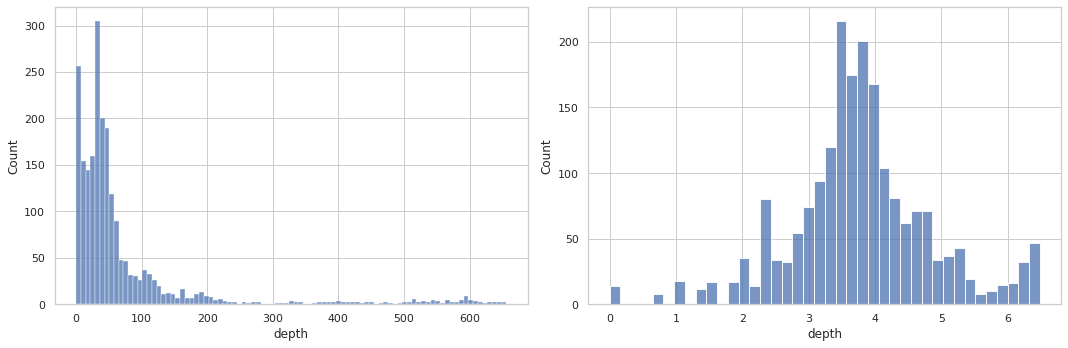

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data=data.loc[:, ["depth"]], x="depth", ax=axes[0])
sns.histplot(np.log(data.loc[data["depth"]>0.01, "depth"]), ax=axes[1])
plt.tight_layout()
plt.show()
# data.loc[data["depth"]>0.01, "depth"] = np.log(data.loc[data["depth"]>0.01, "depth"])

The second problem, that we should solve is that coordinates of quakes are 2 features that represent a three dimensional space. This means that the long coordinate goes all around, which means the two most extreme values are actually very close together. So we have to map them to x, y and z coordinates

In [68]:
data["x"] = np.cos(np.radians(data["latitude"])) * np.cos(np.radians(data["longitude"]))
data["y"] = np.cos(np.radians(data["latitude"])) * np.sin(np.radians(data["longitude"]))
data["z"] = np.sin(np.radians(data["latitude"])) 

Now lets look at waht we've got here

In [69]:
fig = px.scatter_3d(data_frame=data, x='x', y='y', z='z', opacity=0.5, size='depth' ) # , color='species'

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

And finally, let's look at the Richter feature. We can see that there are not enough observations in the last four categories. So let's combine them and create a new category >= 6.5. And then we will apply an ordinal encoder to them and min-max scaler

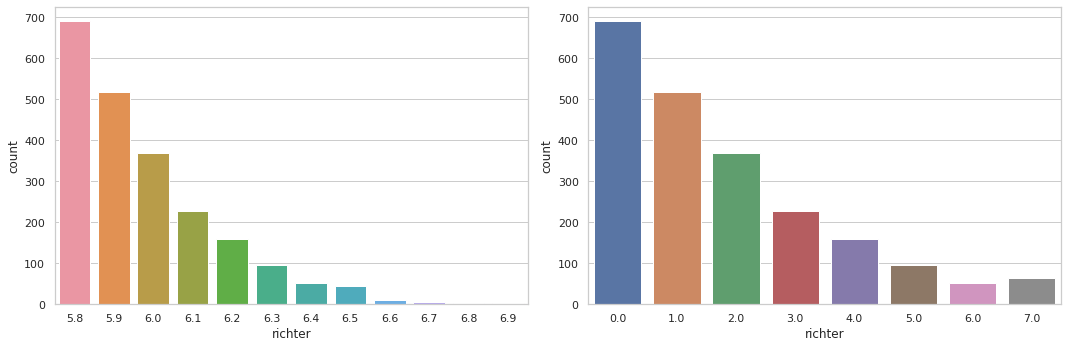

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.countplot(data=data.loc[:, ["richter"]], x="richter", ax=axes[0])

data.loc[data["richter"]>6.5, "richter"] = 6.5

encoder = OrdinalEncoder(categories=[np.sort(data["richter"].unique())])
data.loc[:, "richter"] = encoder.fit_transform(data.loc[:, ["richter"]])

sns.countplot(data=data.loc[:, ["richter"]], x="richter", ax=axes[1])

plt.tight_layout()
plt.show()

In [71]:
# MinMax
scaler = MinMaxScaler(feature_range=(-2, 2))
data.loc[:, ["richter", "depth", "x", "y", "z"]] = scaler.fit_transform(data.loc[:, ["richter", "depth", "x", "y", "z"]])

Now we are ready to draw a pairplot and check the result of our transformations

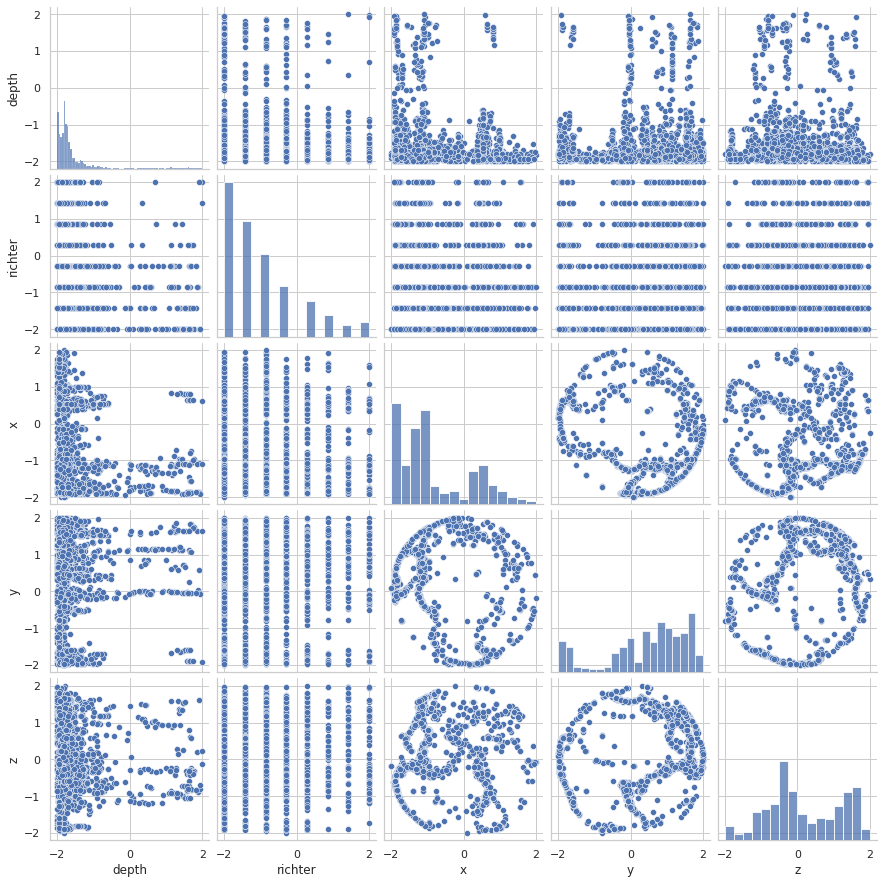

In [72]:
sns.pairplot(data=data.drop(columns=["longitude", "latitude"]))
plt.show()

# Clusterization

In [79]:
class_obj = Pipeline_class(main_data=data.drop(columns=["longitude", "latitude"]))

I am splitting the data into two datasets. The first includes coordinates, the second does not. For each dataset, we are trying to determine the optimal number of clusters for K-Means using the elbow method. We also determine the optimal eps value for DBSCAN using the nearest neighbors method

## 15 K-Means

For n_clusters = 15 The average silhouette_score is : 0.2965252831934014


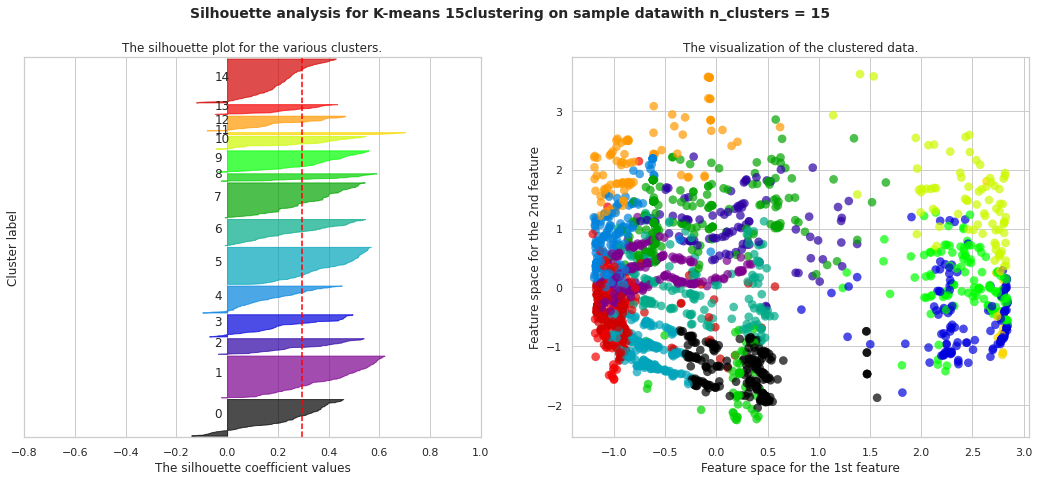

In [74]:
class_obj.kmeans15()
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["k_means15"], n_clusters=class_obj.cluster["k_means15"].nunique(), 
                         title=" K-means 15", full=True)

## Finding the optimal number of clusters

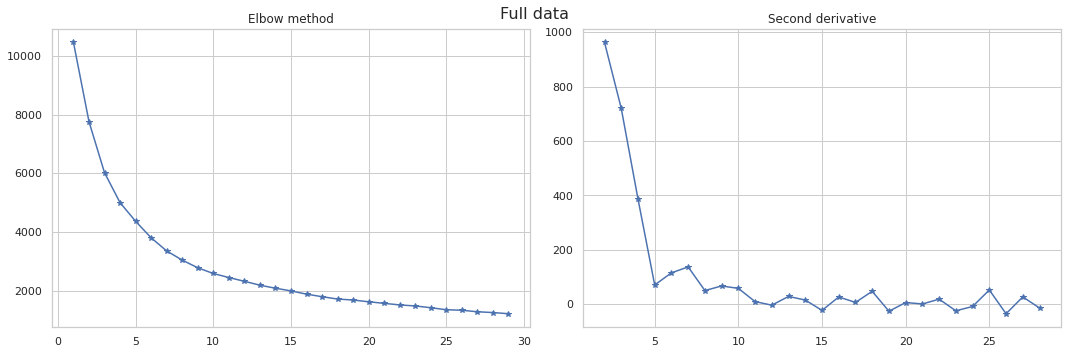

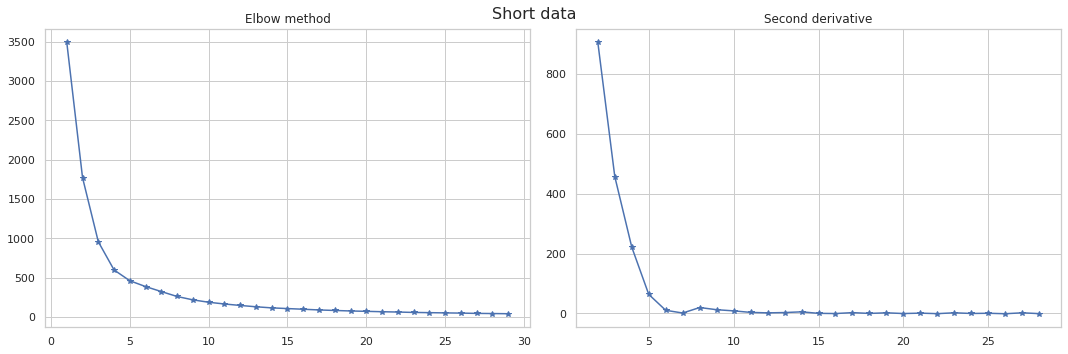

In [ ]:
class_obj.plot_elbow()

The optimal number of clusters for a full dataset is 2 or 7.  
The optimal number of clusters for an incomplete dataset is 2.  

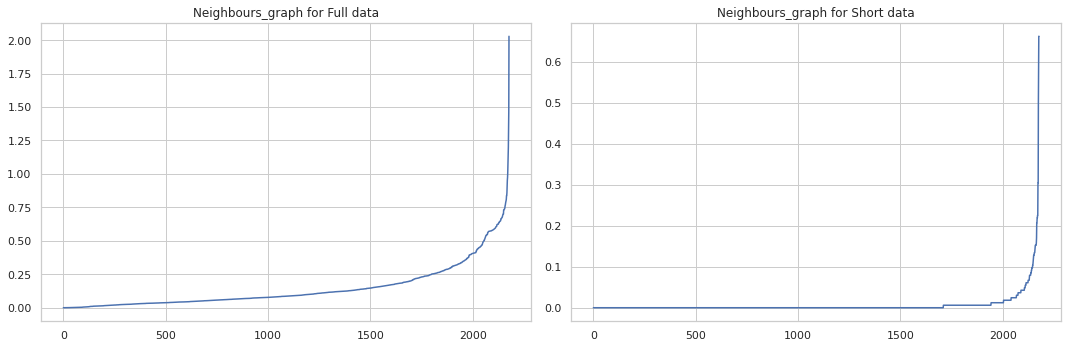

In [ ]:
class_obj.neighbours_graph()

The optimal eps value for a full dataset is 0.6  
For a dataset without coordinates, the optimal eps is 0.02 
Using the results of the work, we can visualize the clusters in a two-dimensional plane

In [122]:
class_obj.make_clusterization(n_cluster_full=2, eps_full=0.55, min_samples_full=7,
                              n_cluster_short=3, eps_short=.02, min_samples_short=4)

# Visualization

Lets check dendrogram

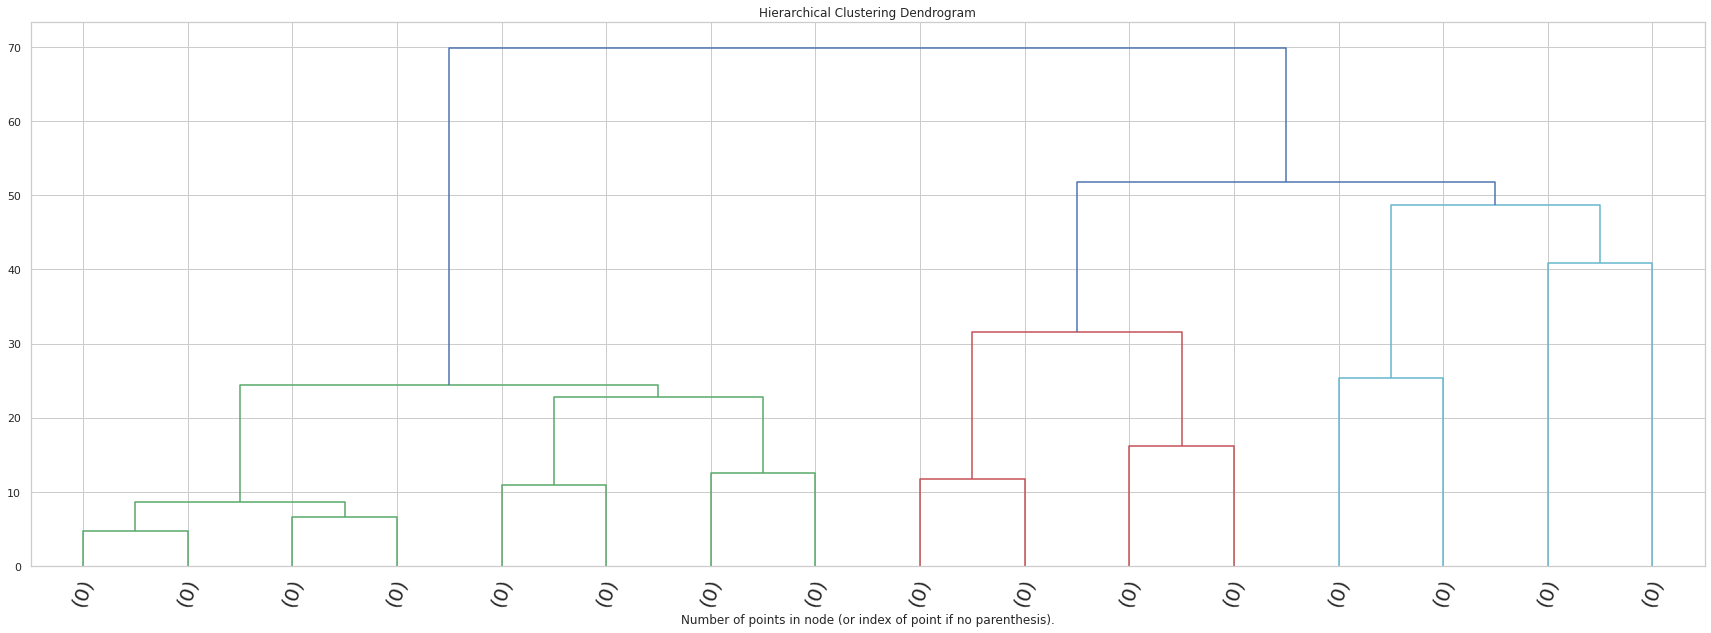

In [ ]:
class_obj.agglomerative(depth=3)

### K-Means

For n_clusters = 2 The average silhouette_score is : 0.3535257538136651


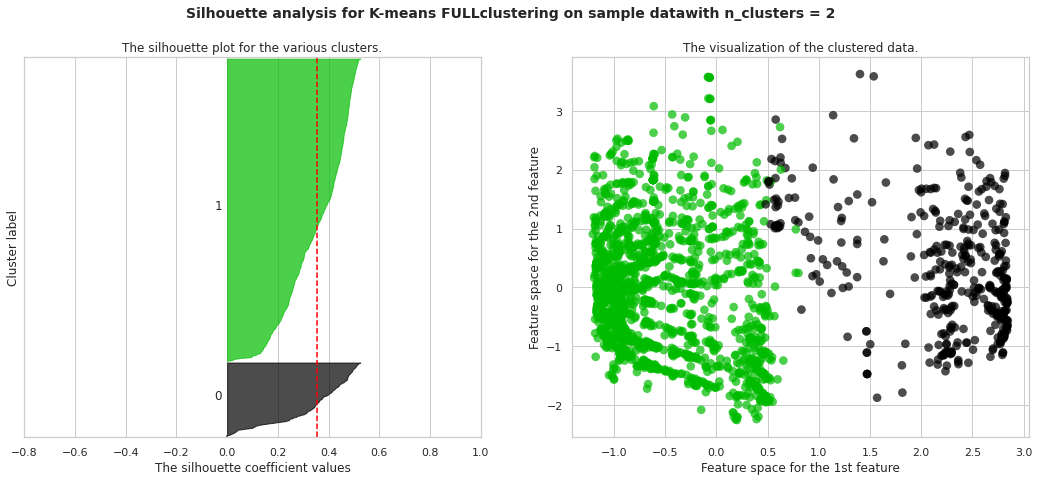

In [ ]:
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["k_means_full"], n_clusters=class_obj.cluster["k_means_full"].nunique(), 
                         title=" K-means FULL", full=True)

Seems nice, but it's kinda weird that we've got only two clusters

For n_clusters = 3 The average silhouette_score is : 0.6100994893615858


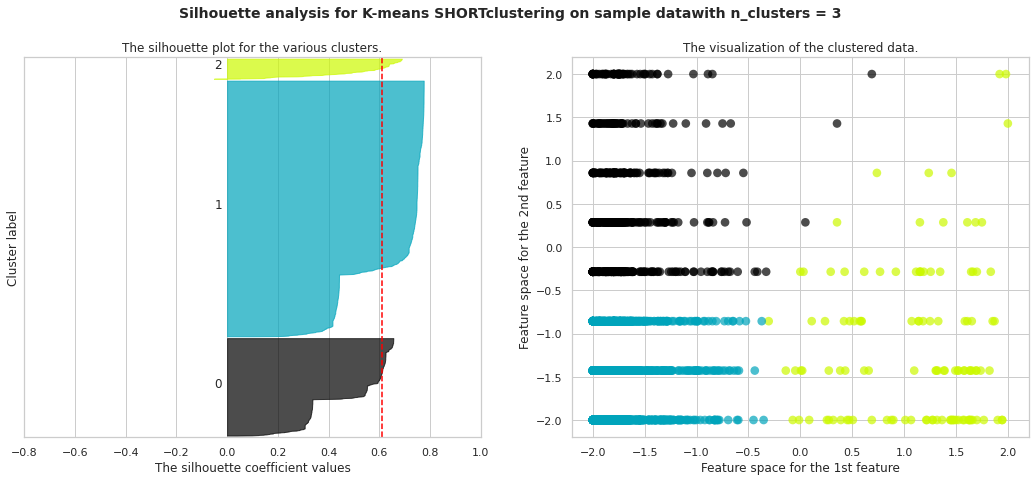

In [ ]:
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["k_means_short"], n_clusters=class_obj.cluster["k_means_short"].nunique(), 
                         title=" K-means SHORT", full=False)

silhouette_score is higher we don't take into account coordinates of quakes

### DBSCAN

For n_clusters = 27 The average silhouette_score is : -0.06533692424122564


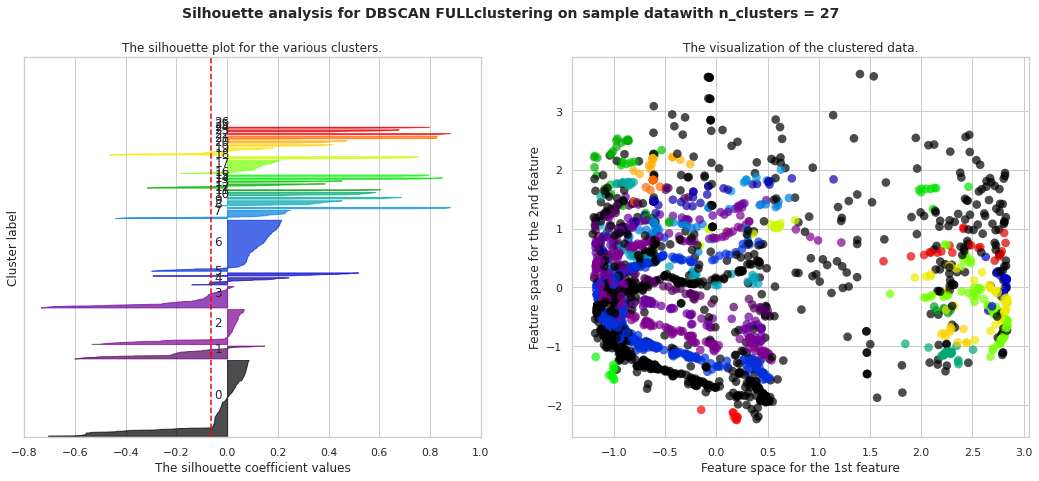

In [ ]:
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["dbscan_full"], n_clusters=class_obj.cluster["dbscan_full"].nunique(), title=" DBSCAN FULL", full=True)

The results are much worse than in k-means case

For n_clusters = 37 The average silhouette_score is : 0.4352908622601821


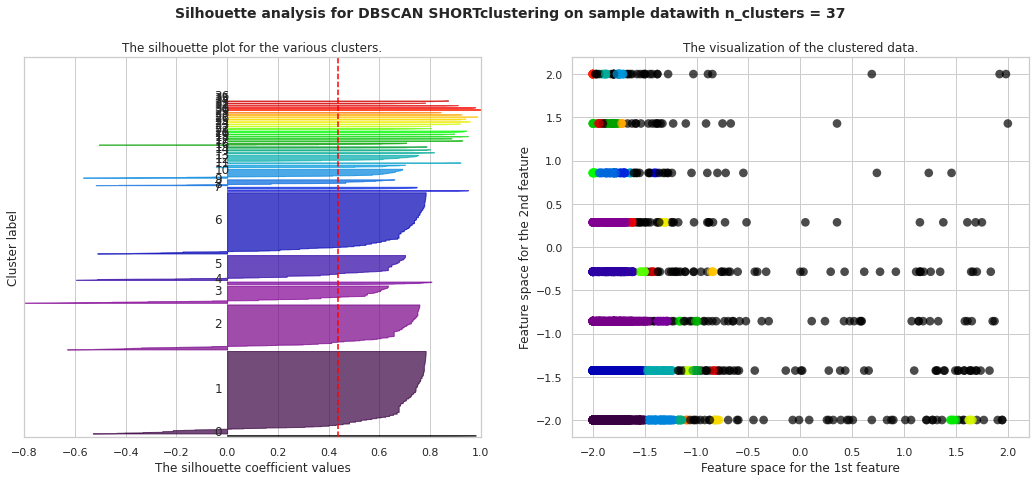

In [ ]:
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["dbscan_short"], n_clusters=class_obj.cluster["dbscan_short"].nunique(), 
                         title=" DBSCAN SHORT", full=False)

Still awful

### agglomerative

For n_clusters = 3 The average silhouette_score is : 0.23853749076068959


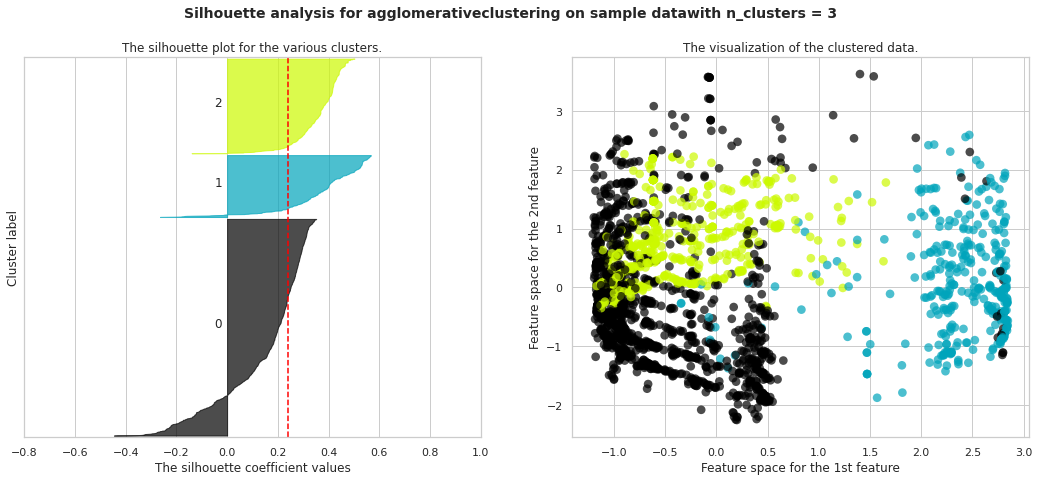

In [ ]:
class_obj.plot_silhoette(cluster_labels=class_obj.cluster["agglomerative"], n_clusters=class_obj.cluster["agglomerative"].nunique(), 
                         title=" agglomerative", full=True)

The results are very similar to K-means

# Metrices

Now lets calculate metrices for this toy example  
First of all, let's assume that the ideal cluster distribution is specified by k-means with 2 clusters

In [84]:
class_obj.metrics(n_clusters=2)

Amount of hyperparameters combinations: 995


  0%|          | 0/995 [00:00<?, ?it/s]

Adjusted MI score for AG = 0.6908326915696991
Adjusted rand score for AG = 0.8161037851506606
Adjusted MI score for DBSCAN = 0.026047568517340997
Adjusted rand score for DBSCAN = 0.04398977988813593


So, as we can see here, the agglomerative clustering results are really similar to k-means. This did not come as a surprise to us, we got similar results at the previous stage.  
Unfortunately, we can't configure DBSCAN for a good solution to this problem.

# Word Map

Lets viaualize k-menas results on WordMap

In [123]:
labels = class_obj.cluster["k_means_full"]
x, y = "latitude", "longitude"
size = "richter"

## create color column
unique_labels = set(labels)
colors = ['green','red']
lst_elements = sorted(list(labels.unique()))
data["color"] = labels.apply(lambda x: colors[lst_elements.index(x)])

## initialize the map with the starting location
world_map = folium.Map(tiles="cartodbpositron", zoom_start=11)

In [124]:
#  add points
data.apply(lambda row: folium.CircleMarker(
        location=[row[x],row[y]],
        color=row["color"], fill=True,
        radius=row[size]*5).add_to(world_map), axis=1)

## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+""":</b><br>"""
for i in lst_elements:
    legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
    fa-1x" style="color:"""+colors[lst_elements.index(i)]+"""">
    </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
world_map.get_root().html.add_child(folium.Element(legend_html))

for i in lst_elements:
    legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
    fa-1x" style="color:"""+colors[lst_elements.index(i)]+"""">
    </i>&nbsp;"""+str(i)+"""<br>"""

## plot the map
world_map

Output hidden; open in https://colab.research.google.com to view.

Okay, as we can see, we divided our objects mainly only by geographic location, the depth and strength of the earthquake had almost no effect on the clustering results.